# Helium Atom

Compute the ground staate and (reduced) electron density for the Helium atom.

In [1]:
using Plots
using LaTeXStrings
using Interact

# set up discrete space grid
n = 50 # even number to avoid singularity at 0
L = 5.
x = collect(linspace(-L, L, n + 2))[2:end-1]
Δx = x[2] - x[1]
X = kron(x, ones(n), ones(n))
Y = kron(ones(n), x, ones(n))
Z = kron(ones(n), ones(n), x)

# discretization of the Hamiltonian
L_1D = spdiagm((-0.5 / Δx^2 * ones(n - 1), -0.5 / Δx^2 * -2. * ones(n), -0.5 / Δx^2 * ones(n - 1)), (-1, 0, 1))
I = speye(n)
L = kron(L_1D, I, I) + kron(I, L_1D, I) + kron(I, I, L_1D)
V_ext = spdiagm(-2 ./ sqrt(X.^2 + Y.^2 + Z.^2)) # external potential for Helium
@time L_LU = lufact(L)

 15.937396 seconds (47.53 k allocations: 2.308 GB, 0.46% gc time)


UMFPACK LU Factorization of a 125000-by-125000 sparse matrix
Ptr{Void} @0x0000000002a3a300


In [2]:
# initialize density
H = L + V_ext
(eigenvalues, eigenfunctions) = eigs(H, which=:SR, nev=1)
ρ = abs2(eigenfunctions[:])

# self consistent iteration
K = 200
α = 1.
tol = 1e-6
E_tot = 0.

@time for k = 1:K
    V_H = spdiagm(2π * (L_LU \ ρ))
    V_xc = spdiagm(-(3 / π)^(1/3) * ρ.^(1/3))
    H = L + V_ext + V_H + V_xc
    (eigenvalues, eigenfunctions) = eigs(H, which=:SR, nev=1, tol=1e-6, v0=eigenfunctions[:])
    eigenfunctions /= Δx^(3/2)
    ρ = α * 2 * abs2(eigenfunctions[:]) + (1 - α) * ρ
    E_kin = Δx^3 * 2 * (eigenfunctions' * L * eigenfunctions)[1]
    E_ext = Δx^3 * sum(V_ext * ρ)
    E_H = Δx^3 / 2 * sum(V_H * ρ)
    E_xc = Δx^3 * (-3 / 4) * (3 / π)^(1 / 3) * sum(ρ.^(4 / 3))
    if abs(E_kin + E_ext + E_H + E_xc - E_tot) < tol
        E_tot = E_kin + E_ext + E_H + E_xc
        println("E_tot = $E_tot, steps = $k")
        break
    end
    E_tot = E_kin + E_ext + E_H + E_xc

    @show E_kin, E_ext, E_H, E_xc, E_tot
#     @show E_tot
end

(E_kin,E_ext,E_H,E_xc,E_tot) = (3.761296297727273,-7.623499087034117,0.007987223165160973,-1.0628412624632086,-4.917056828604892)
(E_kin,E_ext,E_H,E_xc,E_tot) = (1.882718033438556,-5.392044448697045,1.6306972097200787,-0.7095326133548421,-2.5881618188932523)
(E_kin,E_ext,E_H,E_xc,E_tot) = (2.7028179774869536,-6.475478602809686,1.4699305020260698,-0.87453326103467,-3.177263384331332)
(E_kin,E_ext,E_H,E_xc,E_tot) = (2.3047614809645167,-5.975723157165862,1.591600299380858,-0.7970683745165694,-2.8764297513370565)
(E_kin,E_ext,E_H,E_xc,E_tot) = (2.49062716107914,-6.214545477479769,1.5461073099215674,-0.8337965718575788,-3.0116075783366396)
(E_kin,E_ext,E_H,E_xc,E_tot) = (2.402047901820154,-6.101984650336102,1.5701159959623685,-0.8164200374435354,-2.946240789997115)
(E_kin,E_ext,E_H,E_xc,E_tot) = (2.4438768913159534,-6.155416478560413,1.5593192494919925,-0.8246538796447515,-2.976874217397219)
(E_kin,E_ext,E_H,E_xc,E_tot) = (2.4240361106060826,-6.13013489359812,1.5645596566559323,-0.820754684

Interact.Slider{Int64}(Signal{Int64}(25, nactions=0),"j",25,1:50,true)

[Plots.jl] Initializing backend: gr


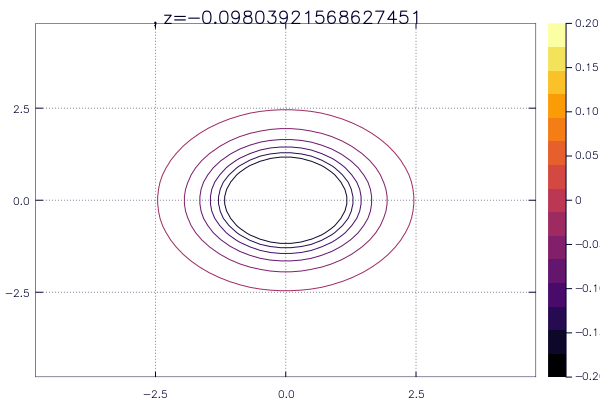

In [3]:
gr()
@manipulate for j = 1:n
    ef = reshape(reshape(eigenfunctions[:], n, n, n)[j, :, :], n, n)
    contour(x, x, ef, title=", z=$(x[j])", zlim=[-0.2, 0.2])
end